In [ ]:
#You might need to install some additonal dependencies (written with ObsPy 1.2.2, Pandas 1.2.3, Numpy 1.20.2, Matplotlib 3.4.1)
%sx pip install obspy numpy pandas matplotlib

In [1]:
import obspy
import requests
import json
import numpy as np
import pandas as pd

from obspy import read
import matplotlib.pyplot as plt

### Upload and run the calibration application services from the terminal before the rest of the notebook
java -jar calibration-application-1.0.*-runnable.jar

Request data from NCEDC

In [2]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
#We could get data from IRIS but we just want Northern Cal data since thats our calibrated model's region
client = Client("http://service.ncedc.org/")

Here I am just picking events at random that I know the calibrated stations were likely to see and we have mws for comparison.

The mw part isn't necessary but makes the plots more challenging to interpret and it would be best to update them to have categorical indicators for the method.

For the sake of simplicity in this example we just limit ourselves, the rest is an exercise left to the reader.

In [3]:
starttime = UTCDateTime("2015/01/01")
endtime = UTCDateTime("2019/12/01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=4.0, minlatitude=36.5, maxlatitude=38.5, minlongitude=-123, maxlongitude=-121)
print(cat)

11 Event(s) in Catalog:
2019-10-15T19:42:30.540000Z | +36.645, -121.274 | 4.71 Mw | manual
2019-10-15T05:33:42.810000Z | +37.938, -122.057 | 4.46 Mw | manual
...
2015-08-17T13:49:17.320000Z | +37.837, -122.232 | 4.01 Mw | manual
2015-05-22T02:53:00.780000Z | +38.432, -122.250 | 4.09 Mw | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [ ]:
st = None

for event in cat.events:
    t = event.origins[0].time
    evid = str(event.resource_id).split("/")[3]
    evlat = event.origins[0].latitude
    evlon = event.origins[0].longitude
    stations = ["BRK", "BKS", "CVS", "MHC", "SAO", "WENL"]
    for sta in stations :
        ste = client.get_waveforms("BK", sta, "*", "BHE", t - 500, t + 3000, attach_response=True)
        stn = client.get_waveforms("BK", sta, "*", "BHN", t - 500, t + 3000, attach_response=True)

        #Instrument correction may be required
        pre_filt = (0.005, 0.006, 30.0, 35.0)           
        ste.remove_response(output='VEL', pre_filt=pre_filt)
        stn.remove_response(output='VEL', pre_filt=pre_filt)

        #ObsPy defaults to m/s for VEL and we want NM/s
        for trace in ste.traces:
            trace.data = trace.data * 1e+9
        for trace in stn.traces:
            trace.data = trace.data * 1e+9        
                    
        sten = ste + stn
        for tr in sten.traces:
            tr.meta["evid"] = evid
            tr.meta["evlat"] = evlat
            tr.meta["evlon"] = evlon
            tr.meta["evtime"] = t
        if (st == None):
            st = sten
        else:
            st = st + sten

print(st)

Saving off the data to save us some time and bandwidth if we need to retrieve the results again

In [ ]:
st.write("data_query_result.pickle")

In [4]:
st = obspy.read("data_query_result.pickle")

Function to convert a Stream to a (minimal) Waveform object

In [5]:
def irisTraceToWaveformJson(stream):   
    obj = []
    for tr in stream.traces:        
        stat = tr.stats
        inventory = client.get_stations(network=stat.network, station=stat.station,
                                starttime=stat.starttime,
                                endtime=stat.endtime)  
        wave = {}
        event = {}
        event["eventId"] = tr.meta["evid"]
        event["originTime"] = str(tr.meta["evtime"])
        event["latitude"] = tr.meta["evlat"]
        event["longitude"] = tr.meta["evlon"]
        wave["event"] = event
        
        stream = {}
        station = {}
        station["networkName"] = stat.network
        station["stationName"] = stat.station
        station["latitude"] = inventory.networks[0].stations[0].latitude
        station["longitude"] = inventory.networks[0].stations[0].longitude
        stream["station"] = station;
        stream["channelName"] = stat.channel
        wave["stream"] = stream
        
        wave["beginTime"] = str(stat.starttime)
        wave["endTime"] = str(stat.endtime)
        wave["sampleRate"] = stat.sampling_rate
        wave["segment"] = tr.data.tolist()
        obj.append(wave)
    
    envelopeJob = {}
    envelopeJob["data"] = obj
    
    return envelopeJob

In [6]:
waveData = irisTraceToWaveformJson(st)

The service uses self signed certs, unless you specify ones to use, so for this example we just ignore the ssl verifcation errors. 

### Do not do this if you are using anything not on localhost in this notebook!

In [7]:
requests.packages.urllib3.disable_warnings()

Post the frequency band based model parameters

In [8]:
with open("norcal_bands.json") as bands:
    norcal_bands = json.load(bands)
    r = requests.post('https://127.0.0.1:53921/api/v1/params/shared-fb-parameters/batch', json=norcal_bands, verify=False)
    print(r.status_code)
    print(r.text)

200



Post the site corrections to the service for northern california (obtained from running the calibration service, not shown here).

In [9]:
with open("norcal_site.json") as corrections:
    norcal_corrections = json.load(corrections)
    r = requests.post('https://127.0.0.1:53921/api/v1/params/site-fb-parameters/batch', json=norcal_corrections, verify=False)
    print(r.status_code)

200


Post the data to the envelopes endpoint and decode the resulting stacks. Note that I am not posting envelope bands in this request and just relying on the default configuration so this will output fewer bands than we actually calibrated against. In practice I would want to submit the bands with the job to get the full spectra I have calibrations for (see EnvelopeJob for the format for that).

In [10]:
r = requests.post('https://127.0.0.1:53921/api/v1/envelopes/create/batch-stacks-only/10000', json=waveData, verify=False)
print(r.status_code)
envData = json.loads(r.text)["resultPayload"]

200


Post data to Mw endpoint and receive the measurements back

In [11]:
request = {
    "stacks": envData,
    "autopickingEnabled":"true"
}
r = requests.post('https://127.0.0.1:53921/api/v1/measurement/measure-mws', json=request, verify=False, timeout=10000)
print(r.status_code)
eventMws = json.loads(r.text)

200


This will return details about the measured events. I'm just picking one to look at here.

In [12]:
print(json.dumps(eventMws["measuredMwDetails"]["72453246"], indent=4, sort_keys=False))

{
    "eventId": "72453246",
    "mw": 4.271013291513935,
    "mwSd": null,
    "mw1Max": 4.357547301878603,
    "mw1Min": 4.173798261585144,
    "mw2Max": 4.357547301878603,
    "mw2Min": 4.062097843507903,
    "refMw": null,
    "valMw": null,
    "apparentStressInMpa": 0.14708008050657245,
    "apparentStress1Max": 0.14708008050657245,
    "apparentStress1Min": 0.14708008050657245,
    "apparentStress2Max": 0.14708008050657245,
    "apparentStress2Min": 0.14708008050657245,
    "refApparentStressInMpa": null,
    "valApparentStressInMpa": null,
    "cornerFreq": 1.029730309287659,
    "cornerFreqSd": null,
    "dataCount": 58,
    "latitude": 38.4316667,
    "longitude": -122.2503333,
    "depth": 0.0,
    "datetime": "2015-05-22T02:53:00.780Z",
    "iterations": 27,
    "misfit": 0.002330191867568431
}


Plot the returned Mws vs the NCEDC Mws

In [13]:
mwcomp = {}

for catEv in cat.events:
#   Note this split is for the NCEDC and how they format their event identification strings, you will need to update this for IRIS or others!
    x = mwcomp.get(str(str(catEv.resource_id).split("/")[3]), {})
    x["eventTime"] = catEv.origins[0].time
    x["ncal_mw"] = catEv.magnitudes[0].mag
    mwcomp[str(str(catEv.resource_id).split("/")[3])] = x

for evs in eventMws["measuredMwDetails"]:
    x = mwcomp.get(str(eventMws["measuredMwDetails"][evs]["eventId"]), {})
    x["cct_mw"] = eventMws["measuredMwDetails"][evs]["mw"]
    x["minMw"] = eventMws["measuredMwDetails"][evs]["mw2Min"]
    x["maxMw"] = eventMws["measuredMwDetails"][evs]["mw2Max"]
    mwcomp[str(eventMws["measuredMwDetails"][evs]["eventId"])] = x
    
df = pd.DataFrame.from_dict(mwcomp, orient='index')

In [14]:
df.sort_values(["ncal_mw"], ascending=True)

,eventTime,ncal_mw,cct_mw,minMw,maxMw
72782971,2017-03-31T10:55:53.700000Z,4.00,3.881875,3.688468,3.979786
72507396,2015-08-17T13:49:17.320000Z,4.01,4.207557,4.075846,4.321306
72906781,2017-10-10T00:53:18.270000Z,4.09,4.156330,4.109885,4.210936
72453246,2015-05-22T02:53:00.780000Z,4.09,4.271013,4.062098,4.357547
73105276,2018-11-02T12:58:54.230000Z,4.11,4.127312,3.979721,4.163055
72663506,2016-07-19T21:38:38.910000Z,4.22,4.331912,4.225718,4.436379
73225421,2019-07-16T20:11:01.470000Z,4.31,4.271586,4.107125,4.366192
72948801,2018-01-04T10:39:37.730000Z,4.38,4.318591,4.227418,4.405946
73291880,2019-10-15T05:33:42.810000Z,4.46,4.539946,4.427682,4.611228
72923380,2017-11-13T19:31:29.050000Z,4.58,4.682418,4.473930,4.781167


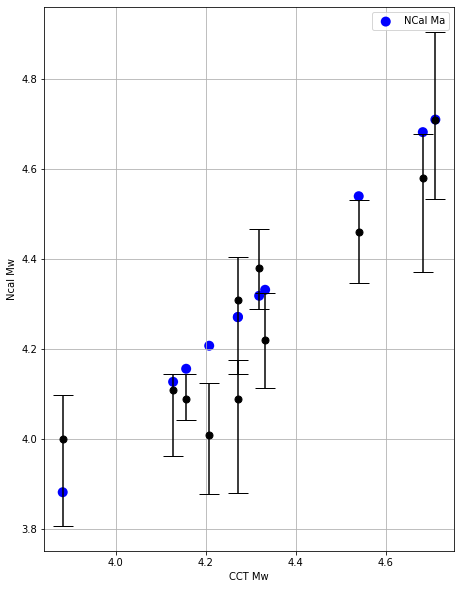

In [15]:
fig, ax = plt.subplots()
x1 = df["cct_mw"]
x2 = df["ncal_mw"]
uqLow = df["cct_mw"]-df["minMw"]
uqHigh = df["maxMw"]-df["cct_mw"]

scale = 100.0

plt.errorbar(x1,x2,yerr=[uqLow, uqHigh], marker="o", linestyle="None", markersize=7, markeredgecolor='black', markerfacecolor='black', capsize=10, color='black')

ax.scatter(x1,x1, c='blue', s=scale, label='NCal Ma',
           alpha=1, edgecolors='none')

ax.legend()
ax.grid(True)
ax.set_aspect(1)
fig.set_size_inches(10,10)
ax.set_ylabel("Ncal Mw")
ax.set_xlabel("CCT Mw")

plt.show()

From this we can see that with this rough calibration I whipped up was not perfect and start to look at where the gaps are and begin refining the calibration. Usually in the CCT GUI application but in practice you could do so entirely using the REST API we have been using in this notebook. 

Also, the envelopes are entirely auto-picked in this instance so tweaking the parameters to use different windows and SNR criteria can likely improve this even with a very rough calibration.

<AxesSubplot:>

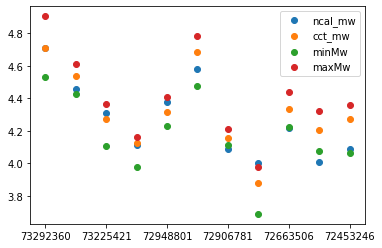

In [16]:
df.plot(marker="o", linestyle="None")

<AxesSubplot:>

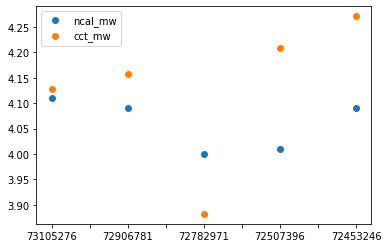

In [17]:
df[df["ncal_mw"] < 4.2][['ncal_mw','cct_mw']].plot(marker="o", linestyle="None")